Iniciando el proceso de compresión de imagen con PCA...
Imagen cargada exitosamente.
Dimensiones de la matriz de la imagen: (1200, 813)
Reconstruyendo con 5 componentes...
Reconstruyendo con 15 componentes...
Reconstruyendo con 45 componentes...
Reconstruyendo con 100 componentes...
Mostrando resultados...


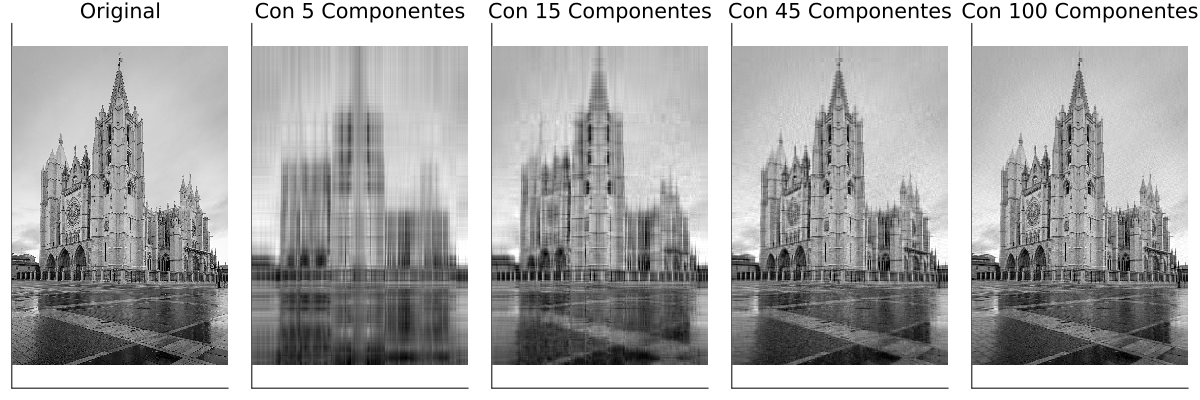

In [1]:

# PCA MATRIZ DE COVARIANZAS


using Images          
using LinearAlgebra   
using Plots           
using Statistics      



"""
Reconstruye una matriz de imagen usando PCA basado en la matriz de covarianzas.

Argumentos:
- matriz_img: La imagen original convertida a una matriz de números.
- num_componentes: El número de componentes principales a usar para la reconstrucción.

Retorna:
- La matriz de la imagen reconstruida.
"""
function pca_covarianza_imagen(matriz_img, num_componentes)
    # a) Centrar los datos: restamos la media de cada columna.
    #    esto es para que la covarianza se calcule bien
    media_por_columna = mean(matriz_img, dims=1)
    matriz_centrada = matriz_img .- media_por_columna

    # b) Calcular la matriz de covarianzas.
    #    esta matriz mide como varian los valores de los pixeles.
    #   este paso consume mucha memoria.
    m, n = size(matriz_centrada)
    matriz_cov = (1 / (n - 1)) * (matriz_centrada * matriz_centrada')

    # c) Calcular los eigenvectores y eigenvalores.
    #    los eigenvectores de la matriz de covarianzas son los componentes principales.
    #    los eigenvalores nos dicen la importancia (la cantidad de varianza) de cada componente.
    valores_propios, vectores_propios = eigen(matriz_cov)

    # d) Ordenar los componentes por importancia (del eigenvalor más alto al más bajo).
    indices_ordenados = sortperm(valores_propios, rev=true)
    componentes_principales = vectores_propios[:, indices_ordenados]

    # e) Seleccionar los 'k' componentes más importantes.
    #    aqui nos quedamos solo con la información esencial.
    W_k = componentes_principales[:, 1:num_componentes]

    # f) Proyectar los datos en el nuevo subespacio de 'k' dimensiones.
    Z = W_k' * matriz_centrada

    # g) Reconstruir la imagen a partir de la proyección, volviendo al espacio original
    #    y añadiendo de nuevo la media que restamos al principio.
    matriz_reconstruida = W_k * Z .+ media_por_columna
    
    return matriz_reconstruida
end




println("Iniciando el proceso de compresión de imagen con PCA...")


try
    #aqui podemos reemplazar con cualquier ruta a una imagen en nuestro entorno local
    global img = load("/Users/leocarpio/Downloads/PHOTO-2025-10-04-14-45-11.jpg") 
    
    println("Imagen cargada exitosamente.")

    # Convertir a escala de grises y luego a una matriz de números
    img_gris = Gray.(img)
    matriz_img = Float64.(img_gris)
    println("Dimensiones de la matriz de la imagen: ", size(matriz_img))

    # Definir con cuántos componentes queremos reconstruir
    componentes_a_probar = [5, 15, 45, 100]
    plots_list = []

    # Añadir la imagen original a la lista de plots para comparar
    p_original = plot(img_gris, title="Original", aspect_ratio=:equal, axis=nothing)
    push!(plots_list, p_original)

    # Reconstruir la imagen para cada número de componentes
    for k in componentes_a_probar
        println("Reconstruyendo con $k componentes...")
        if k <= size(matriz_img, 1)
            img_reconstruida_mat = pca_covarianza_imagen(matriz_img, k)
            
            img_reconstruida_display = Gray.(clamp.(img_reconstruida_mat, 0, 1))
            
            # Crear el plot
            p = plot(img_reconstruida_display, title="Con $k Componentes", aspect_ratio=:equal, axis=nothing)
            push!(plots_list, p)
        else
            println("Se omitió k=$k porque es mayor que la dimensión de la imagen.")
        end
    end

    # mostrar todos los plots juntos en una cuadrícula
    println("Mostrando resultados...")
    plot(plots_list..., layout=(1, length(plots_list)), size=(1200, 400))

catch e
    if e isa SystemError
        println("\nNo se pudo encontrar la imagen.")
    else
        rethrow(e)
    end
end